# **Catégorisez automatiquement des questions**

## partie 1/8 : analyse exploratoire

### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


# 1 EDA, Preprocessing


In [73]:
# Nous avons téléchargé 50 000 questions posées sur stack overflow,
# ainsi que les tags associés.

# Objectifs de cette partie :

# Comprendre nos données (forme, structure)
# premier nettoyage -> reduction dim
# Avoir une première représentation de nos données
# Rechercher des patterns
# se faire une idée de la difficulté de la tâche (prédiction de tags)
# (encore et surtout) : transformations en vue de reduction dim

# tester spacy ?


## 1.1 Importation des librairies, réglages


In [74]:
import os, sys, random
import numpy as np
from zipfile import ZipFile
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import string
from collections import Counter
import spacy

from pandarallel import pandarallel

print('\nPython version ' + sys.version)
print('pandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)

num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")

pandarallel.initialize(progress_bar=True, nb_workers=8)



Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]
pandas version 2.1.1
sns version 0.12.2

Number of CPU cores: 8
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1.2 Fonctions


In [75]:
def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def lerp(a, b, t):
    """
    Linear interpolation between two values 'a' and 'b' at a parameter 't'.
    A very useful little function, used here to position annotations in plots.
    Got it coding with Radu :)

    Given two values 'a' and 'b', and a parameter 't',
    this function calculates the linear interpolation between 'a' and 'b' at 't'.

    Parameters:
    a (float or int): The start value.
    b (float or int): The end value.
    t (float): The interpolation parameter (typically in the range [0, 1], but can be outside).

    Returns:
    float or int: The interpolated value at parameter 't'.
    """
    return a + (b - a) * t


def generate_random_pastel_colors(n):
    """
    Generates a list of n random pastel colors, represented as RGBA tuples.

    Parameters:
    n (int): The number of pastel colors to generate.

    Returns:
    list: A list of RGBA tuples representing random pastel colors.

    Example:
    >>> generate_random_pastel_colors(2)
    [(0.749, 0.827, 0.886, 1.0), (0.886, 0.749, 0.827, 1.0)]
    """
    colors = []
    for _ in range(n):
        # Generate random pastels
        red = round(random.randint(150, 250) / 255.0, 3)
        green = round(random.randint(150, 250) / 255.0, 3)
        blue = round(random.randint(150, 250) / 255.0, 3)

        # Create an RGB color tuple and add it to the list
        color = (red,green,blue, 1.0)
        colors.append(color)

    return colors

print(generate_random_pastel_colors(2))


def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


# ma fonction d'origine (non cleanée)
def hist_distrib(dataframe, feature, bins, r, density=True):
    """
    Affiche un histogramme, pour visualiser la distribution empirique d'une variable
    Argument : df, feature num
    """
    # calcul des tendances centrales :
    mode =  str(round(dataframe[feature].mode()[0], r))
    # mode is often zero, so Check if there are non nul values in the column
    if (dataframe[feature] != 0).any():
        mode_non_nul = str(round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], r))
    else:
        mode_non_nul = "N/A"
    mediane = str(round(dataframe[feature].median(), r))
    moyenne = str(round(dataframe[feature].mean(), r))
    # dispersion :
    var_emp = str(round(dataframe[feature].var(ddof=0), r))
    coeff_var =  str(round(dataframe[feature].std(ddof=0), r)) # = écart-type empirique / moyenne
    # forme
    skewness = str(round(dataframe[feature].skew(), 2))
    kurtosis = str(round(dataframe[feature].kurtosis(), 2))

    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)
    yt = plt.yticks()
    y = lerp(yt[0][0], yt[0][-1], 0.8)
    t = y/20
    xt = plt.xticks()
    x = lerp(xt[0][0], xt[0][-1], 0.7)
    plt.title(feature, pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fs =13
    plt.annotate('Mode : ' + mode, xy = (x, y), fontsize = fs, xytext = (x, y), color = 'g')
    plt.annotate('Mode + : ' + mode_non_nul, xy = (x, y-t), fontsize = fs, xytext = (x, y-t), color = 'g')
    plt.annotate('Médiane : ' + mediane, xy = (x, y-2*t), fontsize = fs, xytext = (x, y-2*t), color = 'g')
    plt.annotate('Moyenne : ' + moyenne, xy = (x, y-3*t), fontsize = fs, xytext = (x, y-3*t), color = 'g')

    plt.annotate('Var emp : ' + var_emp, xy = (x, y-5*t), fontsize = fs, xytext = (x, y-5*t), color = 'g')
    plt.annotate('Coeff var : ' + coeff_var, xy = (x, y-6*t), fontsize = fs, xytext = (x, y-6*t), color = 'g')

    plt.annotate('Skewness : ' + skewness, xy = (x, y-8*t), fontsize = fs, xytext = (x, y-8*t), color = 'g')
    plt.annotate('Kurtosis : ' + kurtosis, xy = (x, y-9*t), fontsize = fs, xytext = (x, y-9*t), color = 'g')
    plt.show()

    return float(skewness) # pour eventuel passage au log

# version cleanée
def hist_distrib(dataframe, feature, bins, decimal_places, density=True):
    """
    Visualize the empirical distribution of a numerical feature using a histogram.
    Calcul des principaux indicateurs de tendance centrale, dispersion et forme.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.
        bins (int): The number of bins for the histogram.
        decimal_places (int): The number of decimal places for rounding numeric values.
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    Returns:
        float: The skewness of the feature's distribution.

    The function generates a histogram of the feature, displays various statistics, and returns the skewness of the distribution.
    """
    # Calculate central tendencies and dispersion
    mode_value = round(dataframe[feature].mode()[0], decimal_places)
    mode_non_zero = "N/A"
    if (dataframe[feature] != 0).any():
        mode_non_zero = round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], decimal_places)
    median_value = round(dataframe[feature].median(), decimal_places)
    mean_value = round(dataframe[feature].mean(), decimal_places)

    # Calculate dispersion
    var_emp = round(dataframe[feature].var(ddof=0), decimal_places)
    coeff_var = round(dataframe[feature].std(ddof=0), decimal_places)

    # Calculate shape indicators
    skewness_value = round(dataframe[feature].skew(), 2)
    kurtosis_value = round(dataframe[feature].kurtosis(), 2)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 5))
    dataframe[feature].hist(density=density, bins=bins, ax=ax)

    # Adjust placement for annotations
    yt = plt.yticks()
    y_position = lerp(yt[0][0], yt[0][-1], 0.8)
    y_increment = y_position / 20
    xt = plt.xticks()
    x_position = lerp(xt[0][0], xt[0][-1], 0.7)

    # Add annotations with horizontal and vertical alignment
    annotation_fs = 13
    color = 'g'
    ax.annotate(f'Mode: {mode_value}', xy=(x_position, y_position), fontsize=annotation_fs,
                xytext=(x_position, y_position), color=color, ha='left', va='bottom')
    ax.annotate(f'Mode +: {mode_non_zero}', xy=(x_position, y_position - y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Median: {median_value}', xy=(x_position, y_position - 2 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 2 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Mean: {mean_value}', xy=(x_position, y_position - 3 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 3 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Var Emp: {var_emp}', xy=(x_position, y_position - 5 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 5 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Coeff Var: {coeff_var}', xy=(x_position, y_position - 6 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 6 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Skewness: {skewness_value}', xy=(x_position, y_position - 8 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 8 * y_increment), color=color, ha='left', va='bottom')
    ax.annotate(f'Kurtosis: {kurtosis_value}', xy=(x_position, y_position - 9 * y_increment), fontsize=annotation_fs,
                xytext=(x_position, y_position - 9 * y_increment), color=color, ha='left', va='bottom')

    # Label the x-axis and y-axis
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Show the plot
    plt.title(f'Distribution of {feature}', pad=20, fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    return skewness_value


def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a box plot of the feature to display central tendencies (median and mean) and dispersion.
    """
    fig, ax = plt.subplots(figsize=(10, 4))

    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

    dataframe.boxplot(feature, vert=False, showfliers=False, medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Calcule l'indice de Gini
    Visualize a Lorenz curve to assess the concentration of a variable and calculate the Gini coefficient.

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to visualize.

    The function generates a Lorenz curve to assess the concentration of the feature and calculates the Gini coefficient.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1)
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0.
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 13, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz

    Args:
        dataframe (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the numerical feature to analyze.
        bins (int, optional): The number of bins for the histogram (default is 50).
        decimal_places (int, optional): The number of decimal places for rounding numeric values (default is 5).
        density (bool, optional): Whether to display the histogram as a density plot (default is True).

    The function generates and displays an analysis of the given numerical feature, including an histogram, a box plot, and a Lorenz curve.
    """
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)


def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes dùun dataframe
    Display the dimensions and the first rows of a DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame to display.
        nb_rows (int, optional): The number of rows to display (default is 5, max is 60).

    The function prints the dimensions of the DataFrame and displays the first few rows.
    """
    print(df.shape)
    display(df.head(nb_rows))


def doughnut(df, feature, title, width=10, height=10):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Display the distribution of a feature as a doughnut chart.
    Les couleurs sont aléatoires.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the feature.
        feature (str): The name of the feature to visualize.
        title (str): The title for the doughnut chart.
        width (int, optional): The width of the chart (default is 10).
        height (int, optional): The height of the chart (default is 10).

    The function creates a doughnut chart to visualize the distribution of the specified feature.
    If you don't like the colors, try running it again :)
    """
    colors = generate_random_pastel_colors(20)

    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    fig, ax = plt.subplots(figsize=(width, height))

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'},
        labeldistance=1.25, pctdistance=0.85, colors=colors)

    plt.title(
    label=title,
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()


def get_non_null_values(df):
    """
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Generate a DataFrame containing the count and proportion of non-null (non-zero) values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    The function calculates and returns a DataFrame with the count and percentage of non-null (non-zero) values for each feature.
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


def get_colors(n=7):
    """
    Generate a list of random colors from multiple colormaps.

    Args:
        n (int, optional): The number of colors to sample from each colormap (default is 7).

    Returns:
        list: A list of random colors sampled from different colormaps.
    """
    num_colors_per_colormap = n
    colormaps = [plt.cm.Pastel2, plt.cm.Set1, plt.cm.Paired]
    all_colors = []

    for colormap in colormaps:
        colors = colormap(np.linspace(0, 1, num_colors_per_colormap))
        all_colors.extend(colors)

    np.random.shuffle(all_colors)

    return all_colors


[(0.722, 0.733, 0.671, 1.0), (0.875, 0.863, 0.941, 1.0)]


## 1.3 importation des données brutes


In [76]:
# Donnees compressées sinon on dépasse la limite /objet de Github (50Mb)

# path to the zip file
zip_file_path = './../data/raw_data/QueryResults.zip'

# directory where you want to extract the contents
extract_to_dir = './../data/raw_data'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_to_dir)

# L'encodage est bien UTF-8 (vérifié en ouvrant le .csv ds vscode)
raw_data = pd.read_csv('./../data/raw_data/QueryResults.csv', sep=',')

quick_look(raw_data)


shape : (50000, 9)


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
0,ImportError: cannot import name 'url_decode' f...,<p>I am building a webapp using Flask. I impor...,<python><flask><importerror><flask-login><werk...,77215107,13,14443,NaN,5,2023-10-02 11:07:45
1,Compilation error after upgrading to JDK 21 - ...,"<p>After upgrading to JDK 21, I have the follo...",<spring-boot><compiler-errors><upgrade><lombok...,77171270,55,36788,NaN,3,2023-09-25 09:05:11
2,Differences between Langchain & LlamaIndex,<p>I'm currently working on developing a chatb...,<chatbot><openai-api><langchain><large-languag...,76990736,28,10433,NaN,2,2023-08-28 07:22:32
3,session not created: This version of ChromeDri...,<p>I am running a Docker image from a Docker c...,<python><amazon-web-services><docker><google-c...,76909437,14,14969,NaN,8,2023-08-15 22:21:03
4,Spring security method cannot decide pattern i...,<p>When I try to run an application it fails t...,<java><spring-boot><eclipse><spring-security><...,76809698,27,18943,NaN,8,2023-08-01 08:16:21


,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
49995,How can I send a file document to the printer ...,<p>Here's the basic premise:</p>\n\n<p>My user...,<c#><winforms><pdf><.net-4.0><printing>,6103705,91,215784,0.0,12,2011-05-23 22:22:56
49996,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"<p>When I run StyleCop, I got this error messa...",<visual-studio><visual-studio-2010><dll><style...,6103133,17,11024,0.0,2,2011-05-23 21:15:51
49997,How to change a text file's name in C++?,<p>I would like to change a <code>txt</code> f...,<c++><algorithm><file><directory><file-rename>,6103036,16,37118,0.0,3,2011-05-23 21:05:59
49998,php implode (101) with quotes,<p>Imploding a simple array </p>\n\n<p>would ...,<php><arrays><string><csv><implode>,6102398,156,141141,0.0,16,2011-05-23 20:06:35
49999,What characters are allowed in a iOS file name?,<p>I'm looking for a way to make sure a string...,<ios><file><filenames><character-encoding><nsf...,6102333,29,26085,0.0,10,2011-05-23 20:00:57


uniques :


Title            49999
Body             50000
Tags             48252
Id               50000
Score              761
ViewCount        36831
FavoriteCount        2
AnswerCount         64
CreationDate     49994
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
Title,Title,0,50000,0.00,object
Body,Body,0,50000,0.00,object
Tags,Tags,0,50000,0.00,object
Id,Id,0,50000,0.00,int64
Score,Score,0,50000,0.00,int64
ViewCount,ViewCount,0,50000,0.00,int64
AnswerCount,AnswerCount,0,50000,0.00,int64
CreationDate,CreationDate,0,50000,0.00,object
FavoriteCount,FavoriteCount,1827,48173,3.65,float64


In [77]:
# Pas de valeurs manquantes, à part FavoriteCount (pas important)

# Seulement 2 titres identiques / 50 000 lignes
# id est bien une clé primaire
# body aussi, pas de questions en doublon (identiques)

# On a environ 48 000 sets de tags différents, vérifier + tard combien de tags uniques

# Les types semblent corrects,
# à part les dates bien sûr

raw_data['CreationDate'] = pd.to_datetime(raw_data['CreationDate'])
# Après je pense qu'on n'utilisera jamais ces dates... Juste au cas où.

raw_data.describe()

# Avec nos critères (cf requete sql, fin ntbk2), il a fallu retourner jusqu'à mai 2011
# pour avoir 50 000 questions. On retrouve ici le favoriteCount très bas, proche de 0.
# On a une moyenne pour le score (environ 50), le nv de vues (66 000) et de réponses (>5)
# dans notre corpus.


,Id,Score,ViewCount,FavoriteCount,AnswerCount,CreationDate
count,5.000000e+04,50000.000000,5.000000e+04,48173.000000,50000.000000,50000
mean,2.878203e+07,49.973980,6.612881e+04,0.000083,5.384480,2015-02-23 09:48:58.933900032
min,6.102333e+06,11.000000,1.000200e+04,0.000000,2.000000,2011-05-23 20:00:57
25%,1.413152e+07,15.000000,1.842050e+04,0.000000,3.000000,2013-01-03 00:42:30.500000
50%,2.551682e+07,24.000000,3.210600e+04,0.000000,4.000000,2014-08-26 23:41:22
75%,4.133835e+07,45.000000,6.446725e+04,0.000000,6.000000,2016-12-27 02:23:45
max,7.721511e+07,27153.000000,1.063924e+07,1.000000,87.000000,2023-10-02 11:07:45
std,1.687404e+07,168.429881,1.424566e+05,0.009112,4.622519,NaN


In [78]:
raw_questions_tags = raw_data[['Body', 'Tags']].copy()

# Rename columns
raw_questions_tags = raw_questions_tags.rename(columns={'Body': 'questions', 'Tags': 'tags'})


## 1.5 Suppression des tags html


In [79]:
raw_questions_tags['questions'] = raw_questions_tags['questions'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
# Le warning n'a pas d'importance ici : du texte qui ne contient pas de tags html
# n'est pas modifié par BeautifulSoup.get_text()

quick_look(raw_questions_tags)


shape : (50000, 2)


,questions,tags
0,I am building a webapp using Flask. I imported...,<python><flask><importerror><flask-login><werk...
1,"After upgrading to JDK 21, I have the followin...",<spring-boot><compiler-errors><upgrade><lombok...
2,I'm currently working on developing a chatbot ...,<chatbot><openai-api><langchain><large-languag...
3,I am running a Docker image from a Docker cont...,<python><amazon-web-services><docker><google-c...
4,When I try to run an application it fails to s...,<java><spring-boot><eclipse><spring-security><...


,questions,tags
49995,Here's the basic premise:\nMy user clicks some...,<c#><winforms><pdf><.net-4.0><printing>
49996,"When I run StyleCop, I got this error message ...",<visual-studio><visual-studio-2010><dll><style...
49997,"I would like to change a txt file's name, but ...",<c++><algorithm><file><directory><file-rename>
49998,Imploding a simple array \nwould look like th...,<php><arrays><string><csv><implode>
49999,I'm looking for a way to make sure a string ca...,<ios><file><filenames><character-encoding><nsf...


uniques :


questions    50000
tags         48252
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
questions,questions,0,50000,0.0,object
tags,tags,0,50000,0.0,object


## 1.6 Tokenisation, majuscules, ponctuation


In [80]:
# switch ?

def preprocess_1_test_tokenizers(text, tok):
    """
    Tokenize the input text based on the specified method.

    Parameters:
    - text (str): Input text to tokenize.
    - tok (str): Tokenization method ('word', 'punct', or 'regex').

    Returns:
    - list: List of tokens.
    """
    text = text.lower().strip()
    try:
        if tok=='word':
            # Tokenize
            tokens = nltk.word_tokenize(text)
        elif tok=='punct':
            tokens = nltk.wordpunct_tokenize(text)
        elif tok=='regex':
            tokenizer = nltk.RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(text)
        else:
            raise ValueError("Invalid tokenization method. Use 'word', 'punct', or 'regex'.")

        # Remove punctuation (make sure)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    return tokens

# Apply the preprocessing functions to the 'questions' column
raw_questions_tags['tokens_word'] = raw_questions_tags['questions'].apply(
    lambda x: preprocess_1_test_tokenizers(x, tok='word'))

raw_questions_tags['tokens_punct'] = raw_questions_tags['questions'].apply(
    lambda x: preprocess_1_test_tokenizers(x, tok='punct'))

raw_questions_tags['tokens_regex'] = raw_questions_tags['questions'].apply(
    lambda x: preprocess_1_test_tokenizers(x, tok='regex'))

display(raw_questions_tags)


,questions,tags,tokens_word,tokens_punct,tokens_regex
0,I am building a webapp using Flask. I imported...,<python><flask><importerror><flask-login><werk...,"[i, am, building, a, webapp, using, flask, i, ...","[i, am, building, a, webapp, using, flask, i, ...","[i, am, building, a, webapp, using, flask, i, ..."
1,"After upgrading to JDK 21, I have the followin...",<spring-boot><compiler-errors><upgrade><lombok...,"[after, upgrading, to, jdk, 21, i, have, the, ...","[after, upgrading, to, jdk, 21, i, have, the, ...","[after, upgrading, to, jdk, 21, i, have, the, ..."
2,I'm currently working on developing a chatbot ...,<chatbot><openai-api><langchain><large-languag...,"[i, 'm, currently, working, on, developing, a,...","[i, m, currently, working, on, developing, a, ...","[i, m, currently, working, on, developing, a, ..."
3,I am running a Docker image from a Docker cont...,<python><amazon-web-services><docker><google-c...,"[i, am, running, a, docker, image, from, a, do...","[i, am, running, a, docker, image, from, a, do...","[i, am, running, a, docker, image, from, a, do..."
4,When I try to run an application it fails to s...,<java><spring-boot><eclipse><spring-security><...,"[when, i, try, to, run, an, application, it, f...","[when, i, try, to, run, an, application, it, f...","[when, i, try, to, run, an, application, it, f..."
...,...,...,...,...,...
49995,Here's the basic premise:\nMy user clicks some...,<c#><winforms><pdf><.net-4.0><printing>,"[here, 's, the, basic, premise, my, user, clic...","[here, s, the, basic, premise, my, user, click...","[here, s, the, basic, premise, my, user, click..."
49996,"When I run StyleCop, I got this error message ...",<visual-studio><visual-studio-2010><dll><style...,"[when, i, run, stylecop, i, got, this, error, ...","[when, i, run, stylecop, i, got, this, error, ...","[when, i, run, stylecop, i, got, this, error, ..."
49997,"I would like to change a txt file's name, but ...",<c++><algorithm><file><directory><file-rename>,"[i, would, like, to, change, a, txt, file, 's,...","[i, would, like, to, change, a, txt, file, s, ...","[i, would, like, to, change, a, txt, file, s, ..."
49998,Imploding a simple array \nwould look like th...,<php><arrays><string><csv><implode>,"[imploding, a, simple, array, would, look, lik...","[imploding, a, simple, array, would, look, lik...","[imploding, a, simple, array, would, look, lik..."


## 1.7 tokens uniques


In [81]:
def preprocess_2_keep_uniques_only(liste_tokens):
    seen_tokens = set()
    unique_tokens = []

    for token in liste_tokens:
        if token not in seen_tokens:
            seen_tokens.add(token)
            unique_tokens.append(token)

    return unique_tokens

# Apply the preprocessing function
raw_questions_tags['tokens_uniques_word'] = raw_questions_tags['tokens_word'].apply(preprocess_2_keep_unique_tokens)
raw_questions_tags['tokens_uniques_punct'] = raw_questions_tags['tokens_punct'].apply(preprocess_2_keep_unique_tokens)
raw_questions_tags['tokens_uniques_regex'] = raw_questions_tags['tokens_regex'].apply(preprocess_2_keep_unique_tokens)


In [82]:
# Compare

tokenizers = ['word', 'punct', 'regex']

for t in tokenizers:
    raw_questions_tags['nb_mots_' + str(t)] = raw_questions_tags['tokens_' + str(t)].apply(len)
    raw_questions_tags['nb_mots_uniques_' + str(t)] = raw_questions_tags['tokens_uniques_' + str(t)].apply(len)

    print(f'Résultat avec le tokeniser {t} :')
    print(raw_questions_tags['nb_mots_' + str(t)].sum())
    print(raw_questions_tags['nb_mots_uniques_' + str(t)].sum(), '\n')

    display(raw_questions_tags[['nb_mots_' + str(t), 'nb_mots_uniques_' + str(t)]].describe())


Résultat avec le tokeniser word :
9032441
4797454 



,nb_mots_word,nb_mots_uniques_word
count,50000.000000,50000.000000
mean,180.648820,95.949080
std,189.014106,67.644649
min,6.000000,6.000000
25%,77.000000,53.000000
50%,128.000000,79.000000
75%,216.000000,118.000000
max,3700.000000,2083.000000


Résultat avec le tokeniser punct :
10854995
5129601 



,nb_mots_punct,nb_mots_uniques_punct
count,50000.000000,50000.000000
mean,217.099900,102.592020
std,269.783592,72.499908
min,7.000000,7.000000
25%,84.000000,56.000000
50%,143.000000,84.000000
75%,250.000000,127.250000
max,5186.000000,2007.000000


Résultat avec le tokeniser regex :
9933371
4779099 



,nb_mots_regex,nb_mots_uniques_regex
count,50000.000000,50000.000000
mean,198.667420,95.581980
std,242.687884,67.057986
min,7.000000,7.000000
25%,79.000000,53.000000
50%,133.000000,79.000000
75%,228.000000,118.000000
max,4845.000000,1993.000000


In [83]:
# regex l'emporte ici de peu sur word, apres le filtage des tokens presents plusieurs fois
#  -> meilleure gestion (découpage) des adresses mail, url, liens, etc... ?


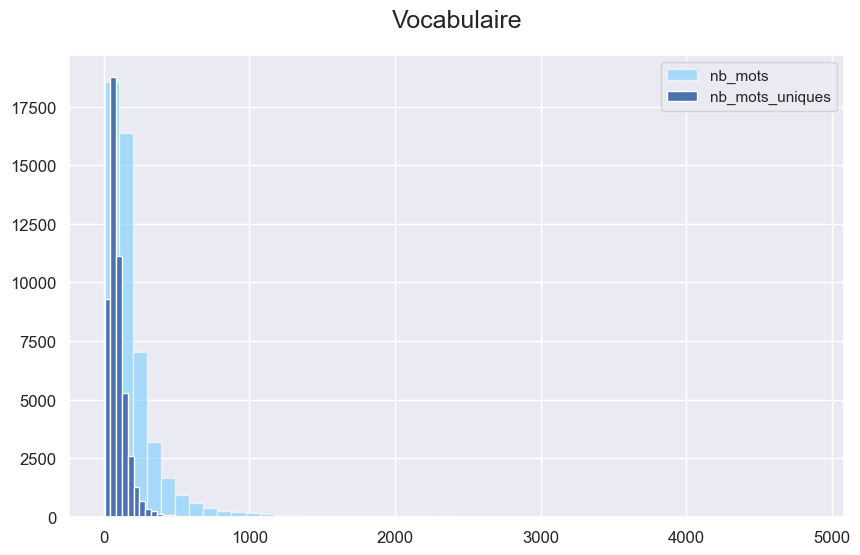

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_mots_regex'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.6, label='nb_mots')

# Plotting 'nb_mots_uniques'
raw_questions_tags['nb_mots_uniques_regex'].hist(density=False, bins=50, ax=ax, label='nb_mots_uniques')


plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()


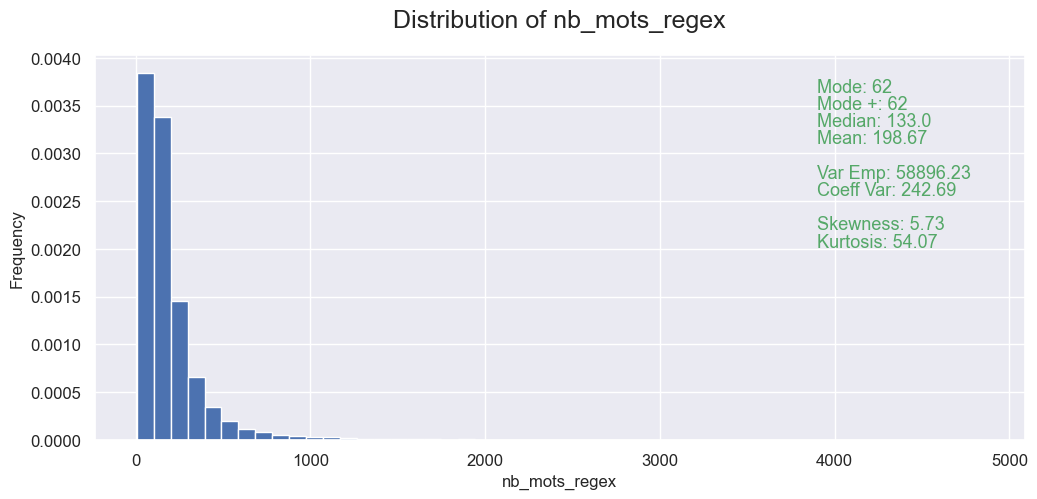

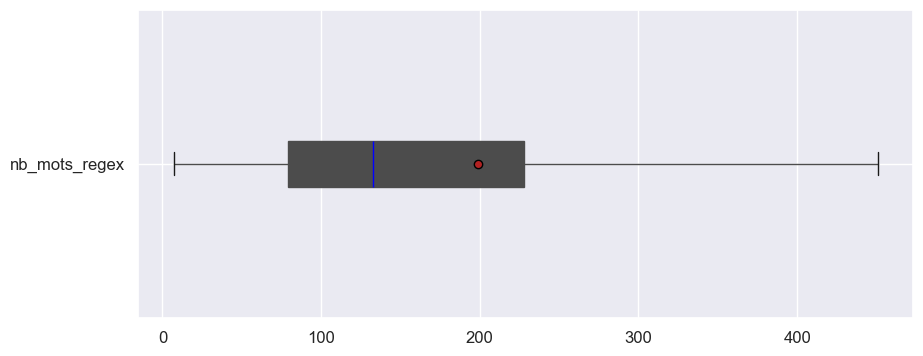

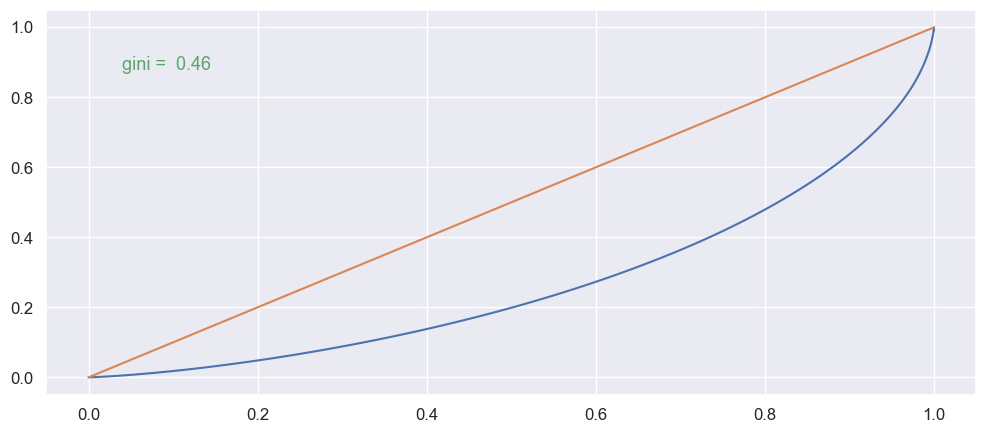

In [85]:
graphs_analyse_uni(raw_questions_tags, 'nb_mots_regex', bins=50, r=2, density=True)


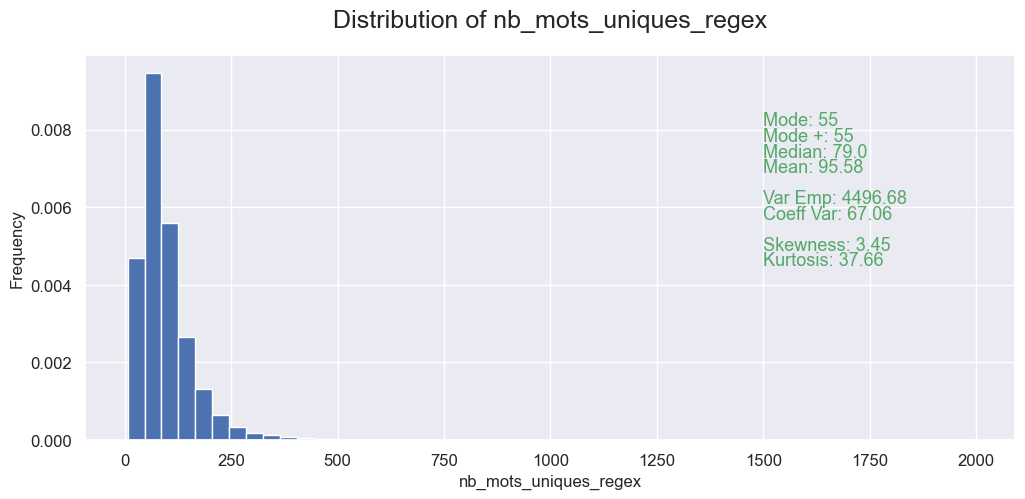

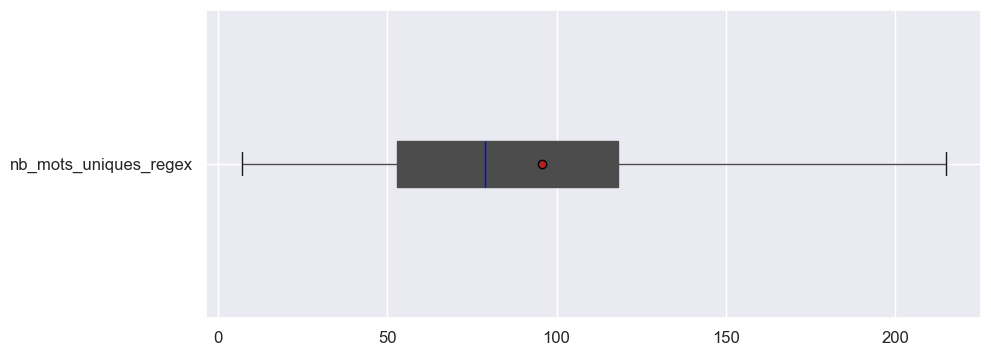

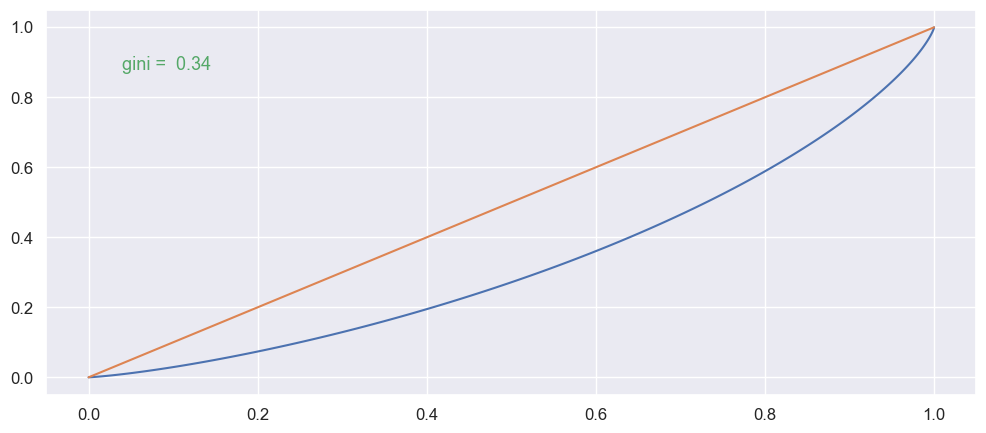

In [86]:
graphs_analyse_uni(raw_questions_tags, 'nb_mots_uniques_regex', bins=50, r=2, density=True)

# moyenne divisée par 2


## 1.8 Fréquence des mots


In [87]:
# Extract tokens from the 'tokens_uniques' column
all_tokens = [token for tokens_list in raw_questions_tags['tokens_uniques_regex'] for token in tokens_list]
print (len(all_tokens))

# Calculate token frequencies using a loop
token_frequencies_dict = {}
for token in all_tokens:
    token_frequencies_dict[token] = token_frequencies_dict.get(token, 0) + 1

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(token_frequencies_dict.items())[:50]:
    print(f"{token}: {frequency}")


4779099
i: 47655
am: 16582
building: 1250
a: 40027
webapp: 239
using: 20601
flask: 245
imported: 360
the: 45254
login: 1325
library: 3049
to: 46346
handle: 1419
user: 6236
but: 29129
it: 32606
shows: 1643
an: 18546
importerror: 225
below: 4791
is: 39583
my: 25439
folder: 1667
structure: 1006
flask_blog1: 1
flaskblog: 1
static: 2783
templates: 307
__init__: 584
py: 1510
forms: 501
models: 869
routes: 440
instance: 2190
site: 1868
db: 1509
venv: 90
requirements: 353
txt: 896
run: 7431
from: 19220
import: 4796
app: 8133
if: 19275
__name__: 260
__main__: 239
debug: 1848
true: 6691
flask_sqlalchemy: 12
sqlalchemy: 154


In [88]:
# Sort the dictionary items by values in descending order
sorted_token_frequencies = dict(sorted(token_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:50]:
    print(f"{token}: {frequency}")

# La plupart de ces mots appartiennent probablement à la liste des stopwords


i: 47655
to: 46346
the: 45254
a: 40027
is: 39583
and: 37811
in: 37741
this: 34135
it: 32606
of: 30620
but: 29129
for: 28252
that: 27263
have: 26311
with: 25917
my: 25439
not: 23646
can: 23516
on: 22202
using: 20601
how: 20584
be: 19796
if: 19275
t: 19266
from: 19220
as: 18979
an: 18546
when: 17251
do: 17144
1: 16928
or: 16634
am: 16582
so: 16511
like: 16244
what: 16084
get: 15918
code: 15693
m: 15588
there: 15290
s: 15123
use: 15087
0: 14694
any: 14497
are: 13658
2: 13351
error: 13117
which: 12997
want: 12748
new: 12223
all: 11635


## 1.9 Stopwords


In [89]:
# Get a set of English stop words from NLTK
stopwords = set(nltk.corpus.stopwords.words('english'))

# Update the set with additional stop words if needed (most frequent ?)
# stopwords.update(['additional', 'stop', 'words'])

important_tokens = [token for token in all_tokens if token not in stopwords]
print(len(important_tokens))

# Display the first 50 items in the token frequencies dictionary
for token, frequency in list(sorted_token_frequencies.items())[:50]:
    if token not in important_tokens:
        print(f"{token}: {frequency}")

# Il y a encore bcp de mots très commun. Pas sûr où placer le seuil


3455272
i: 47655
to: 46346
the: 45254
a: 40027
is: 39583
and: 37811
in: 37741
this: 34135
it: 32606
of: 30620
but: 29129
for: 28252
that: 27263
have: 26311
with: 25917
my: 25439
not: 23646
can: 23516
on: 22202
how: 20584
be: 19796
if: 19275
t: 19266
from: 19220
as: 18979
an: 18546
when: 17251
do: 17144
or: 16634
am: 16582
so: 16511
what: 16084
m: 15588
there: 15290
s: 15123
any: 14497
are: 13658
which: 12997
all: 11635


In [90]:
def preprocess_text_3(liste_tokens):
    filtered_list = [token for token in liste_tokens if token not in stopwords]

    return filtered_list

# Apply the preprocessing function
raw_questions_tags['tokens_uniques_no_stopwords'] = raw_questions_tags['tokens_uniques_regex'].apply(preprocess_text_3)

raw_questions_tags['nb_tokens_uniques_no_stopwords'] = raw_questions_tags['tokens_uniques_no_stopwords'].apply(len)


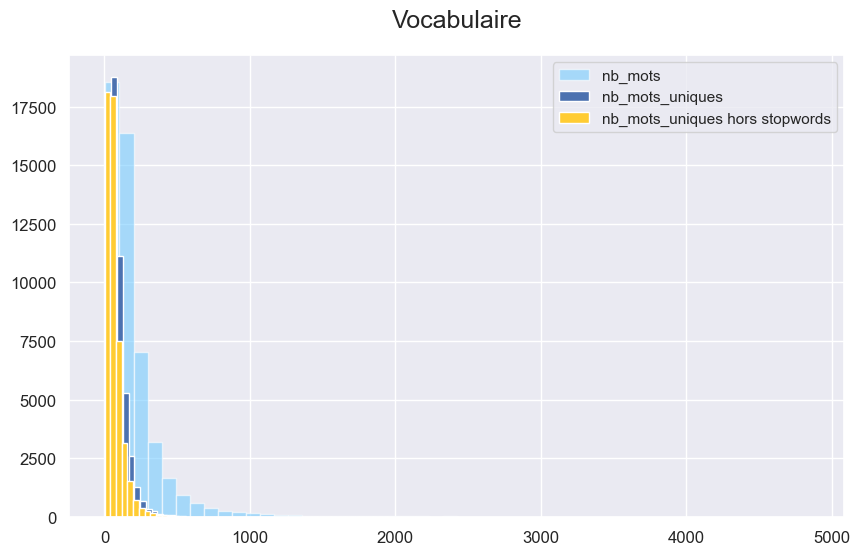

In [91]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_mots_regex'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.6, label='nb_mots')

# Plotting 'nb_mots_uniques'
raw_questions_tags['nb_mots_uniques_regex'].hist(density=False, bins=50, ax=ax, label='nb_mots_uniques')

# Plotting 'nb_mots_uniques non stopwords'
raw_questions_tags['nb_tokens_uniques_no_stopwords'].hist(density=False, bins=50, color='#fc3', ax=ax,
                                                          label='nb_mots_uniques hors stopwords')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()


## 1.10 Lemmatization / stemming


In [92]:
# Lemmatization tends to be more accurate but can be slower than stemming.
# On a utilisé le stemming en français, dans le cours openclassrooms
# Tentons donc la lemmatisation ici
# Developper ?

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(pos_tag):
        if pos_tag.startswith('J'):
            return wordnet.ADJ
        elif pos_tag.startswith('V'):
            return wordnet.VERB
        elif pos_tag.startswith('N'):
            return wordnet.NOUN
        elif pos_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to noun if the part of speech is not recognized

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags]

    return lemmatized_tokens


raw_questions_tags['lemms'] = raw_questions_tags['tokens_uniques_no_stopwords'].apply(lemmatize_tokens)

# garde seulmt les lemmes uniques
raw_questions_tags['lemms_uniques'] = raw_questions_tags['lemms'].apply(preprocess_2_keep_uniques_only)

raw_questions_tags['nb_lemms'] = raw_questions_tags['lemms'].apply(len)
raw_questions_tags['nb_lemms_uniques'] = raw_questions_tags['lemms_uniques'].apply(len)


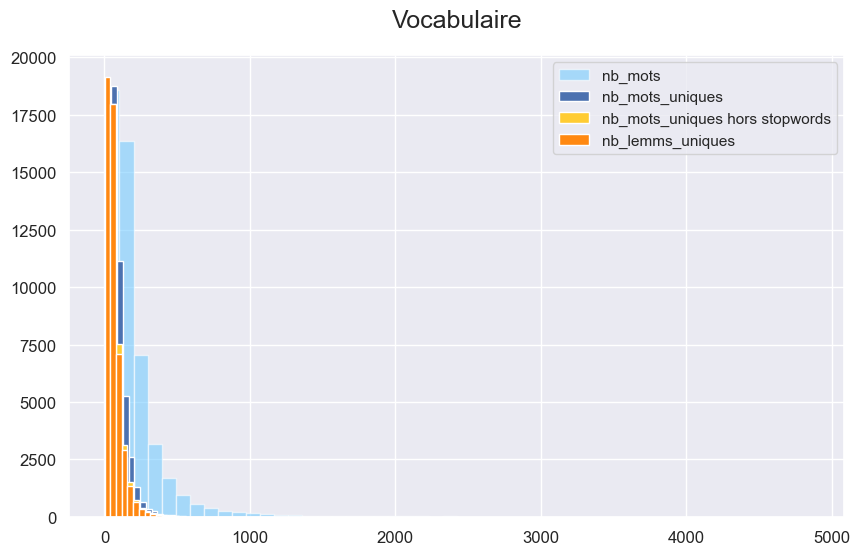

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting 'nb_mots'
raw_questions_tags['nb_mots_regex'].hist(density=False, bins=50, ax=ax, color='#7cf', alpha=0.6, label='nb_mots')

# Plotting 'nb_mots_uniques'
raw_questions_tags['nb_mots_uniques_regex'].hist(density=False, bins=50, ax=ax, label='nb_mots_uniques')

# Plotting 'nb_mots_uniques non stopwords'
raw_questions_tags['nb_tokens_uniques_no_stopwords'].hist(density=False, bins=50, color='#fc3', ax=ax,
                                                          label='nb_mots_uniques hors stopwords')
# Plotting 'lemms'
raw_questions_tags['nb_lemms_uniques'].hist(density=False, bins=50, color='#f81', ax=ax,
                                                          label='nb_lemms_uniques')

plt.title('Vocabulaire', pad=20, fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.legend()

plt.show()


## 1.11 Explorer le corpus obtenu


In [94]:
# Affichons 20 questions au hasard (+ les tags)

# display(raw_questions_tags[['questions', 'lemms']].sample(20))

display(raw_questions_tags.sample(20))

# I'm ? C lematisé ça ?


,questions,tags,tokens_word,tokens_punct,tokens_regex,tokens_uniques_word,tokens_uniques_punct,tokens_uniques_regex,nb_mots_word,nb_mots_uniques_word,nb_mots_punct,nb_mots_uniques_punct,nb_mots_regex,nb_mots_uniques_regex,tokens_uniques_no_stopwords,nb_tokens_uniques_no_stopwords,lemms,lemms_uniques,nb_lemms,nb_lemms_uniques
16055,I do get these errors after i updated Android ...,<android><android-studio><build><dependencies>...,"[i, do, get, these, errors, after, i, updated,...","[i, do, get, these, errors, after, i, updated,...","[i, do, get, these, errors, after, i, updated,...","[i, do, get, these, errors, after, updated, an...","[i, do, get, these, errors, after, updated, an...","[i, do, get, these, errors, after, updated, an...",3494,339,3997,370,3868,346,"[get, errors, updated, android, studio, sdk, e...",300,"[get, error, update, android, studio, sdk, err...","[get, error, update, android, studio, sdk, war...",300,290
49328,"I like to give helpful errors / messages, and ...",<c++><templates><c++11><custom-errors><static-...,"[i, like, to, give, helpful, errors, messages,...","[i, like, to, give, helpful, errors, messages,...","[i, like, to, give, helpful, errors, messages,...","[i, like, to, give, helpful, errors, messages,...","[i, like, to, give, helpful, errors, messages,...","[i, like, to, give, helpful, errors, messages,...",498,168,552,186,499,161,"[like, give, helpful, errors, messages, also, ...",113,"[like, give, helpful, error, message, also, wa...","[like, give, helpful, error, message, also, wa...",113,106
33767,I am currently working with the nopCommerce so...,<c#><overriding><virtual><nopcommerce><partial...,"[i, am, currently, working, with, the, nopcomm...","[i, am, currently, working, with, the, nopcomm...","[i, am, currently, working, with, the, nopcomm...","[i, am, currently, working, with, the, nopcomm...","[i, am, currently, working, with, the, nopcomm...","[i, am, currently, working, with, the, nopcomm...",154,87,159,86,157,85,"[currently, working, nopcommerce, source, code...",57,"[currently, work, nopcommerce, source, code, t...","[currently, work, nopcommerce, source, code, t...",57,53
5251,I am using .netcore 2 with JwtSecurityToken to...,<c#><.net-core><jwt><asp.net-core-2.0><asp.net...,"[i, am, using, .netcore, 2, with, jwtsecurityt...","[i, am, using, netcore, 2, with, jwtsecurityto...","[i, am, using, netcore, 2, with, jwtsecurityto...","[i, am, using, .netcore, 2, with, jwtsecurityt...","[i, am, using, netcore, 2, with, jwtsecurityto...","[i, am, using, netcore, 2, with, jwtsecurityto...",107,64,123,68,112,63,"[using, netcore, 2, jwtsecuritytoken, generate...",40,"[use, netcore, 2, jwtsecuritytoken, generate, ...","[use, netcore, 2, jwtsecuritytoken, generate, ...",40,38
15887,I have a simple configuration with webpack-dev...,<express><reactjs><webpack-hmr><webpack-hot-mi...,"[i, have, a, simple, configuration, with, webp...","[i, have, a, simple, configuration, with, webp...","[i, have, a, simple, configuration, with, webp...","[i, have, a, simple, configuration, with, webp...","[i, have, a, simple, configuration, with, webp...","[i, have, a, simple, configuration, with, webp...",256,161,353,180,301,149,"[simple, configuration, webpack, dev, middlewa...",123,"[simple, configuration, webpack, dev, middlewa...","[simple, configuration, webpack, dev, middlewa...",123,118
16210,I am running OLS regression using pandas.stats...,<python><csv><pandas><linear-regression><stats...,"[i, am, running, ols, regression, using, panda...","[i, am, running, ols, regression, using, panda...","[i, am, running, ols, regression, using, panda...","[i, am, running, ols, regression, using, panda...","[i, am, running, ols, regression, using, panda...","[i, am, running, ols, regression, using, panda...",304,140,268,161,238,138,"[running, ols, regression, using, pandas, stat...",107,"[run, ols, regression, use, pandas, stats, api...","[run, ols, regression, use, pandas, stats, api...",107,106
17351,I am trying to 

In [95]:
# Pistes restantes

# Handling Numeric Values:
# Decide whether to keep or remove numeric values based on their relevance to your prediction task.
# Rare Words: Consider removing or replacing rare words to reduce the dimensionality of your data.
# Contractions: Expand contractions to ensure consistency (e.g., "don't" to "do not").
# URLs and Email Addresses

# Pour les tags
# Label Encoding: If your tags are categorical, encode them into numerical labels.


## 1.12 Target


In [96]:
def preprocess_tags(tags_string):
    # just in case
    tags_string = tags_string.lower()
    # Split tags by '><'
    tags_list = tags_string.split('><')

    # Remove angle brackets from the first and last tag
    tags_list[0] = tags_list[0][1:]
    tags_list[-1] = tags_list[-1][:-1]

    return tags_list

# Apply the preprocessing function to the 'tags' column
raw_questions_tags['tags_list'] = raw_questions_tags['tags'].apply(preprocess_tags)

display(raw_questions_tags[['tags', 'tags_list']].head(10))


,tags,tags_list
0,<python><flask><importerror><flask-login><werk...,"[python, flask, importerror, flask-login, werk..."
1,<spring-boot><compiler-errors><upgrade><lombok...,"[spring-boot, compiler-errors, upgrade, lombok..."
2,<chatbot><openai-api><langchain><large-languag...,"[chatbot, openai-api, langchain, large-languag..."
3,<python><amazon-web-services><docker><google-c...,"[python, amazon-web-services, docker, google-c..."
4,<java><spring-boot><eclipse><spring-security><...,"[java, spring-boot, eclipse, spring-security, ..."
5,<python><python-3.x><google-chrome><selenium-w...,"[python, python-3.x, google-chrome, selenium-w..."
6,<ios><flutter><xcode><macos><build>,"[ios, flutter, xcode, macos, build]"
7,<python><nlp><importerror><huggingface-transfo...,"[python, nlp, importerror, huggingface-transfo..."
8,<firebase><next.js><oauth-2.0><firebase-authen...,"[firebase, next.js, oauth-2.0, firebase-authen..."
9,<javascript><node.js><reactjs><babeljs><ejs>,"[javascript, node.js, reactjs, babeljs, ejs]"


In [97]:
all_tags = [tag for tags in raw_questions_tags['tags_list'] for tag in tags]
print(len(all_tags))

# Au cas où il y aurait des doublons ds les tags
raw_questions_tags['tags_uniques'] = raw_questions_tags['tags'].apply(preprocess_2_keep_uniques_only)

# Fréquence
# Factoriser
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Display the first 50 items in the tag frequencies dictionary
for tag, frequency in list(sorted_tag_frequencies.items())[:50]:
    print(f"{tag}: {frequency}")

# 250 000 tags (différents) !
# Ca repond a la question : est-ce qu'un humain pourrait facilement faire cette tache.
# Il faudrait déjà connaitre ts les tags possibles... Pas évident.

# Le tag le plus présent est python
# Est-ce qu'il y a plus de codeurs en python qu'en javascript ?
# Peut-être. Pas sûr.
# Est-ce qu'on va sur stack overflow plus souvent quand on fait du python ?
# Je dirais que oui. Il y a tjs de nveaux modules à découvrir en python !

# Classement intéressant !


250002
python: 6500
javascript: 6174
java: 6097
c#: 4728
android: 4265
ios: 4024
html: 2500
c++: 2086
node.js: 1965
php: 1929
jquery: 1858
.net: 1787
css: 1736
objective-c: 1550
spring: 1542
swift: 1412
linux: 1304
iphone: 1302
reactjs: 1287
json: 1236
xcode: 1215
sql: 1177
asp.net: 1103
pandas: 1029
python-3.x: 1015
arrays: 925
c: 911
mysql: 906
asp.net-mvc: 904
typescript: 880
angular: 877
spring-boot: 857
windows: 818
unit-testing: 806
django: 796
string: 779
ruby-on-rails: 772
macos: 714
numpy: 677
database: 676
angularjs: 657
sql-server: 644
laravel: 644
rest: 640
postgresql: 635
dataframe: 632
bash: 631
amazon-web-services: 621
asp.net-core: 609
docker: 608


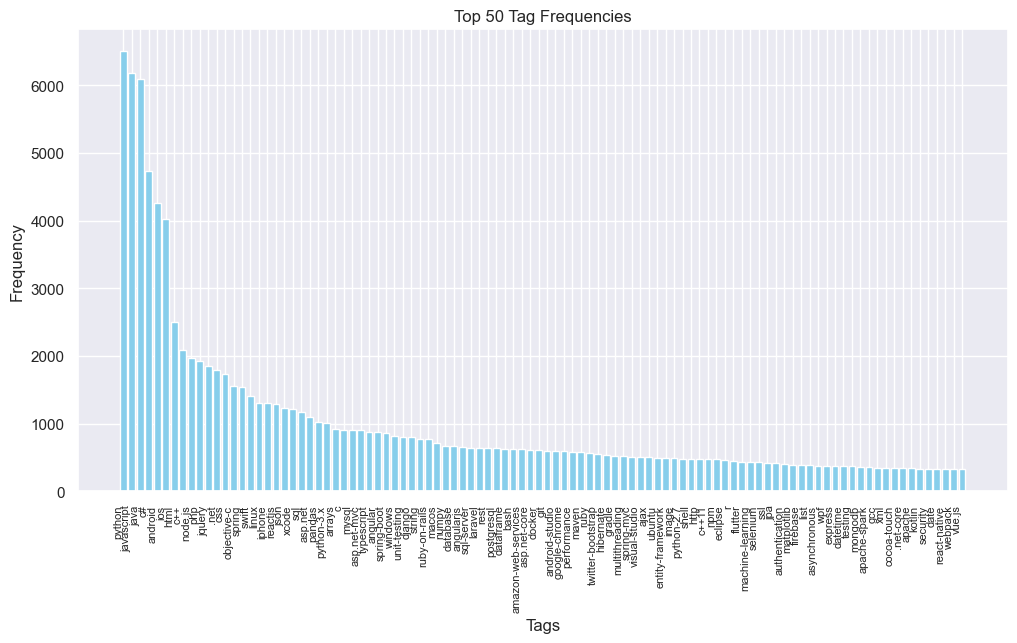

In [98]:
# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

# Plot
plt.figure(figsize=(12, 6))
plt.bar(tags[:100], frequencies[:100], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 50 Tag Frequencies')
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotate x-axis labels for better readability
plt.show()


,Tag,Frequency
0,python,6500
1,javascript,6174
2,java,6097
3,c#,4728
4,android,4265


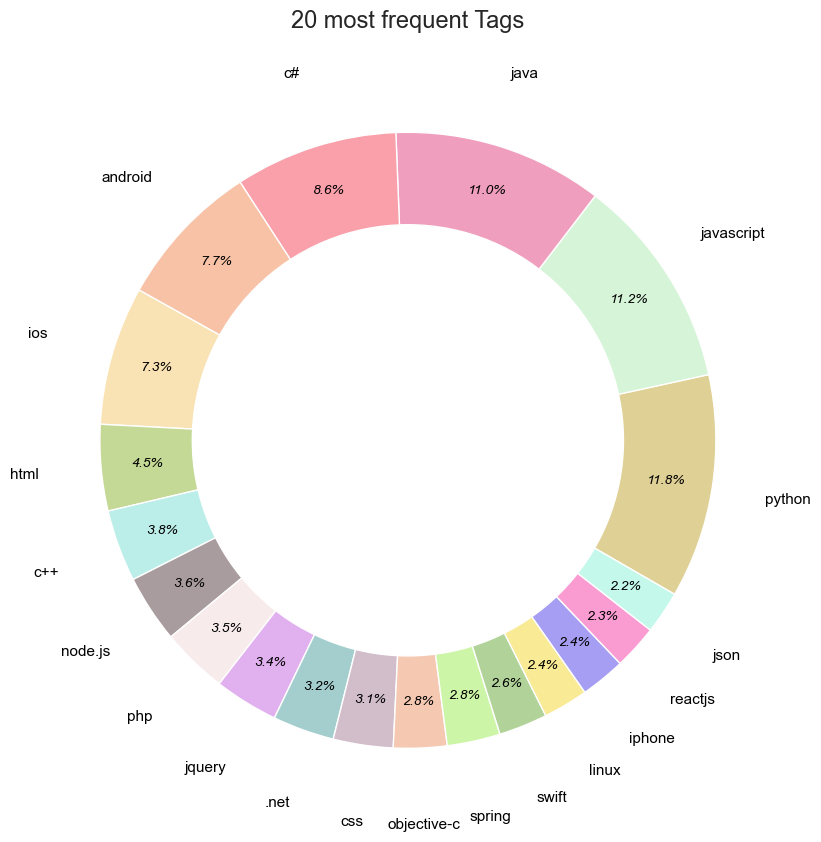

In [99]:
# + d'un tiers des question concernent python, js ou java.

# Faisons un top 20
df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})

# Display the DataFrame
display(df_freq.head())

# plot a pie
colors = generate_random_pastel_colors(20)

fig, ax = plt.subplots(figsize=(10, 10))

patches, texts, autotexts = plt.pie(x=df_freq['Frequency'][:20], autopct='%1.1f%%',
    startangle=-30, labels=df_freq['Tag'][:20], textprops={'fontsize':11, 'color':'#000'},
    labeldistance=1.25, pctdistance=0.85, colors=colors)

plt.title(
label='20 most frequent Tags',
fontdict={"fontsize":17},
pad=20
)

for text in texts:
    # text.set_fontweight('bold')
    text.set_horizontalalignment('center')

# Customize percent labels
for autotext in autotexts:
    autotext.set_horizontalalignment('center')
    autotext.set_fontstyle('italic')
    autotext.set_fontsize('10')

#draw circle
centre_circle = plt.Circle((0,0),0.7,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()


In [100]:
# A l'inverse, certains tags sont rares

# Count tags with frequency less than 10
tags_below_10 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency < 10)
print(tags_below_10)

# voire tres rares
# tags hapax (1 seule occurence)

# Count tags with frequency less than 2
tags_below_2 = sum(1 for frequency in sorted_tag_frequencies.values() if frequency < 2)
print(tags_below_2)


13253
6526


In [101]:
# analyse multi ?


## 2.1 Normalisation
